Fitting 3 folds for each of 81 candidates, totalling 243 fits
✅ Best Parameters (XGBoost): {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500, 'subsample': 1.0}


C:\Users\ACER\PycharmProjects\PythonProject\.venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ACER\PycharmProjects\PythonProject\.venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


💾 Model saved as xgb_unemployment_model.pkl
Train Set Evaluation:
MAE: 0.779
MSE: 2.466
R² Score: 0.695

Test Set Evaluation:
MAE: 0.799
MSE: 2.512
R² Score: 0.694


📊 Feature Importance (XGBoost):
                  Feature  Importance
6   age_group_clean_20-24    0.434713
5   age_group_clean_15-19    0.396855
7   age_group_clean_25-29    0.052328
12     age_group_clean_60    0.022262
2            time_index_q    0.021227
11  age_group_clean_50-59    0.016809
3        sex_clean_female    0.014892
10  age_group_clean_40-49    0.014655
0                    year    0.011899
4          sex_clean_male    0.005468
9   age_group_clean_35-39    0.004653
1             quarter_num    0.003596
8   age_group_clean_30-34    0.000643


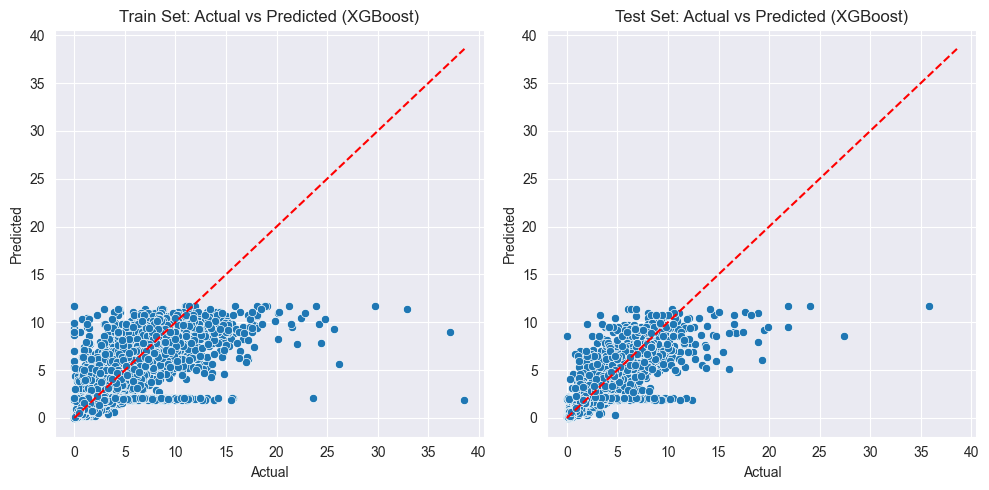

In [16]:
# ------------------------------
# 1. Import Libraries
# ------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ------------------------------
# 2. Load Data
# ------------------------------
df = pd.read_csv(r'C:\Users\ACER\PycharmProjects\PythonProject\data\unemployment_ml_ready_clean1.csv')

# ------------------------------
# 3. Select Features and Target
# ------------------------------
features = [
    'year', 'quarter_num', 'time_index_q',
    'sex_clean_female', 'sex_clean_male',
    'age_group_clean_15-19', 'age_group_clean_20-24',
    'age_group_clean_25-29', 'age_group_clean_30-34',
    'age_group_clean_35-39', 'age_group_clean_40-49',
    'age_group_clean_50-59', 'age_group_clean_60'
]
X = df[features]
y = df['value_pct']

# ------------------------------
# 4. Split Train/Test
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# 5. XGBoost Regressor + Hyperparameter Tuning
# ------------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
}

grid_search = GridSearchCV(
    xgb_model, param_grid,
    cv=3, scoring='r2', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters (XGBoost):", grid_search.best_params_)

# ------------------------------
# 6. Refit Best Model with Early Stopping
# ------------------------------
best_xgb = XGBRegressor(
    **grid_search.best_params_,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False
)

# ------------------------------
# 7. Save & Load Model (Deploy Ready)
# ------------------------------
joblib.dump(best_xgb, "FastAPI/app/xgb_unemployment_model.pkl")
print("💾 Model saved as xgb_unemployment_model.pkl")

# ตัวอย่างการโหลดกลับมาใช้
loaded_model = joblib.load("FastAPI/app/xgb_unemployment_model.pkl")

# ------------------------------
# 8. Predict และ Evaluate
# ------------------------------
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)

def evaluate(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Evaluation:")
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"R² Score: {r2:.3f}\n")

evaluate(y_train, y_train_pred, "Train Set")
evaluate(y_test, y_test_pred, "Test Set")

# ------------------------------
# 9. Feature Importance
# ------------------------------
importances = loaded_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)
print("\n📊 Feature Importance (XGBoost):")
print(feat_imp)

# ------------------------------
# 10. Visualization: Actual vs Predicted
# ------------------------------
plt.figure(figsize=(10,5))

# Train Set
plt.subplot(1,2,1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Train Set: Actual vs Predicted (XGBoost)')

# Test Set
plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Test Set: Actual vs Predicted (XGBoost)')

plt.tight_layout()
plt.show()


In [7]:
test_case = pd.DataFrame([{
    'year': 2026,
    'quarter_num': 2,
    'time_index_q': 146,
    'sex_clean_female': 0,
    'sex_clean_male': 1,
    'age_group_clean_15-19': 0,
    'age_group_clean_20-24': 1,
    'age_group_clean_25-29': 0,
    'age_group_clean_30-34': 0,
    'age_group_clean_35-39': 0,
    'age_group_clean_40-49': 0,
    'age_group_clean_50-59': 0,
    'age_group_clean_60': 0
}])

print(best_xgb.predict(test_case))

[4.0684175]
